In [3]:
%load_ext autoreload
%cd ..

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/tomhanlon58/Desktop/NoisyGAN


In [4]:
%autoreload 2
%reload_ext autoreload
%pwd
from core import *
import gin
gin.enter_interactive_mode()

In [23]:
batch_size = 8

data_provider = FromTFRecords('./Data/test/acapella.tfrecord*')
gan_model = GAN(Generator(latent_dim=100), Discriminator(batch_size=batch_size))
combined_iter = combined_sample_iter(gan_model.gen, data_provider, batch_size=batch_size)
opt = tf.keras.optimizers.Adam()

# params:  5275005



In [6]:
# Testing Saving/Loading Weights
gan_model.save_weights("test")

In [12]:
gan_model2 = GAN(Generator(latent_dim=100), Discriminator(batch_size=batch_size))
gan_model2.load_weights("test")

# params:  5275005



In [34]:
# Initialize Checkpoints
from core.gan.training import AudiofileCheckpoint, LossCheckpoint

checkpoint = AudiofileCheckpoint("Notebooks/Checkpoints/", "chkpt-iter{0[iter]}-loss{0[loss]}.wav", DEFAULT_SAMPLE_RATE, period=2)
savetofile = LossCheckpoint("Notebooks/Checkpoints/disc_losses.txt", "Notebooks/Checkpoints/gen_losses.txt", DEFAULT_SAMPLE_RATE, period=1)
chkpts = [checkpoint, savetofile]

In [35]:
train_gan(gan_model, opt, combined_iter, batch_size=batch_size, iters=2, disc_iters = 1, gen_iters = 1, checkpoints = chkpts)
savetofile.savetofile()

INFO:absl:discriminator step0:
INFO:absl:generating... batch 5
INFO:absl:Disc Loss: 1.3488561
INFO:absl:Gen Loss: 11.099625
INFO:absl:discriminator step1:
INFO:absl:generating... batch 6


Saved  Notebooks/Checkpoints/chkpt-iter0-loss11.099624633789062.wav


INFO:absl:Disc Loss: 1.387109
INFO:absl:Gen Loss: 11.10248


In [38]:
tf.reduce_sum(gan_model.losses).numpy()

11.10248

In [28]:
play(gan_model.gen.generate()['audio'])

dict_keys(['audio', 'f0_hz', 'loudness_db', 'label'])


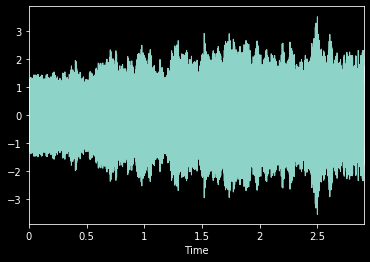

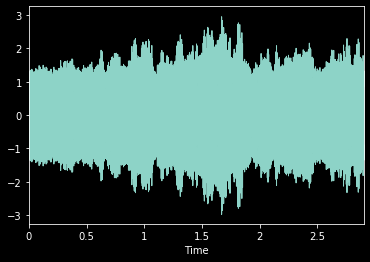

In [140]:
from scipy.io import wavfile
x = gan_model.gen.generate()
print(x.keys())
wavePlot(x['audio'])
wavePlot(y['audio'])

wavfile.write('Notebooks/Checkpoints/out_test.wav', DEFAULT_SAMPLE_RATE, x['audio'].numpy())

In [30]:
play(gan_model.gen.generate()['audio'])

In [17]:
# Test Strategy

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    batch_size = 8

    data_provider = FromTFRecords('./Data/test/acapella.tfrecord*')
    gan_model = GAN(Generator(latent_dim=100), Discriminator(batch_size=batch_size))
    combined_iter = combined_sample_iter(gan_model.gen, data_provider, batch_size=batch_size)
    opt = tf.keras.optimizers.Adam()
    
    train_gan(gan_model, opt, combined_iter, batch_size=batch_size, iters=1)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:absl:discriminator step0:
INFO:absl:generating... batch 0


# params:  5275005



RuntimeError: `add_update` was called in a cross-replica context. This is not expected. If you require this feature, please file an issue.

In [15]:
train_gan(gan_model, opt, combined_iter, batch_size=batch_size, iters=1)

INFO:absl:discriminator step0:
INFO:absl:generating... batch 0
INFO:absl:Disc Loss: 6.4412847


ValueError: Trying to create optimizer slot variable under the scope for tf.distribute.Strategy (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x13aae33c8>), which is different from the scope used for the original variable (MirroredVariable:{
  0 /job:localhost/replica:0/task:0/device:CPU:0: <tf.Variable 'conv2d_18/kernel:0' shape=(3, 3, 1, 16) dtype=float32, numpy=
array([[[[-0.02507295, -0.05780853,  0.03900176, -0.07334261,
          -0.19103065, -0.06596898, -0.09259333, -0.0400466 ,
           0.15236025, -0.06637228,  0.19078018, -0.11183748,
           0.12196769, -0.01493546, -0.06741036, -0.18902548]],

        [[-0.1394892 , -0.14173503,  0.11963548, -0.07248525,
          -0.15624183, -0.1430955 , -0.03899416,  0.05955492,
           0.05745514, -0.16676417, -0.10048646,  0.00644352,
          -0.02922253,  0.0481369 ,  0.09450959, -0.18283573]],

        [[ 0.02182685,  0.09906413,  0.0876175 , -0.00999689,
           0.10021167, -0.01140943,  0.05131255,  0.14599095,
           0.0164074 , -0.01731807,  0.09586255,  0.04984854,
           0.11488147,  0.07698919, -0.08037503, -0.04996119]]],


       [[[-0.00572488,  0.11379819, -0.04358637, -0.08539297,
           0.1882862 , -0.05027309, -0.18451938,  0.06190474,
          -0.15882094,  0.08070089,  0.03427064,  0.01318184,
          -0.05998853,  0.11136757,  0.07438858,  0.04510771]],

        [[-0.10576006,  0.12664126,  0.13291831,  0.01155598,
           0.11699404,  0.14015432, -0.08837264,  0.05186392,
          -0.17862685,  0.12528272, -0.19623694,  0.16004322,
           0.11102058, -0.1635793 , -0.00958565,  0.1159244 ]],

        [[-0.13504708,  0.08991022, -0.08524977, -0.15816194,
           0.04576279, -0.17155264,  0.01023971, -0.15194325,
          -0.1511917 ,  0.06835835, -0.04060656, -0.10512503,
           0.05555175, -0.04725432, -0.00491227,  0.02334799]]],


       [[[ 0.03956063, -0.18704055,  0.03896555,  0.03893963,
           0.1617613 ,  0.02225301,  0.11884309, -0.04141934,
          -0.09208781,  0.1227719 , -0.1141919 ,  0.11490799,
           0.17241259, -0.09392826,  0.14972775, -0.01475129]],

        [[ 0.04454736,  0.03499429, -0.1321221 ,  0.00496326,
          -0.0360423 , -0.10778738,  0.15693064,  0.03504764,
           0.06368543, -0.17527768, -0.03142615,  0.04957144,
          -0.10949633,  0.06559078, -0.15005824,  0.01371823]],

        [[-0.05223837,  0.00532846,  0.17298688,  0.1918409 ,
           0.0961719 , -0.05381432,  0.17214684,  0.03439784,
           0.08695541,  0.02082969, -0.16674797, -0.00538433,
          -0.14303252,  0.12948458, -0.15321076,  0.14196412]]]],
      dtype=float32)>
}). Make sure the slot variables are created under the same strategy scope. This may happen if you're restoring from a checkpoint outside the scope